In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9vvkj8w6
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9vvkj8w6
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=9df503260e4c1104a2ade6e5cd0af2f6520e1b8ccc371d71869c86ee8d855a9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-ydx2mow5/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [3]:
from keras.layers import ELU, PReLU, LeakyReLU

In [4]:
cd keras-contrib

[Errno 2] No such file or directory: 'keras-contrib'
/content


In [97]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

## Helper Function

In [6]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(128, 128)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [7]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    print("generate fake instance, samples.shape: ", samples.shape)
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [8]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')

    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))

## Generator

In [9]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='SAME')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d



    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    print("\n______GENERATOR______:\n ", in_img.shape)
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    # print(u1.shape, d5.shape)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(1, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

## Discriminator

In [22]:
def discriminator(img_shape):
    print("\n\n\nHERE: img_shape is:", img_shape)
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    # in_src_img = Input(shape=img_shape)
    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)
    print("in_src_img.shape = ", in_src_img.shape, "in_target_img.shape = ", in_target_img.shape)
    merged = Concatenate()([in_src_img, in_target_img])
    print("merged.shape is ", merged.shape)

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)
    print('d4.shape = ', d4.shape)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same', name="OLOLO")(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

## GAN

In [11]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    print("in_img.shape = ", in_img.shape, "gen_out.shape = ", gen_out.shape)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

## Train GAN model

In [70]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        blue_photo, blue_sketch = shuffle(blue_photo, blue_sketch)

        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            # select a batch of real samples
            print("select a batch of real samples")
            [X_realB, X_realA], y_real = generate_real_samples(dataset, n_batch, n_patch)
            # ИСПРАВЛЕНО !

            # generate a batch of fake samples
            X_realA = tf.reduce_mean(X_realA, axis=3)
            X_realA = X_realA[:, :, :, tf.newaxis]
            print("generate a batch of fake samples: X_realA.shape: ", X_realA.shape, "X_realB.shape is", X_realB.shape, "\n")
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # update discriminator for generated samples
            print("update discriminator for generated samples")
            d_loss = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            # update the generator
            print("update the generator")
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))
            # if j > 15:
            #   break

        # summarize model performance
        summarize_performance(i, g_model, d_model, dataset, target_dir)

## Loss Function

In [92]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 128, 128, 1]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 128, 128, 1]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    return px_loss

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Dataset

In [53]:
# SKETCH
b_photo_path = '/content/drive/MyDrive/Training_data_17.09.2023/Full_Training-sketches/'
# EMOJI
b_sketch_path = '/content/drive/MyDrive/Training_data_17.09.2023/Training-emojis/'


blue_photo = load_filename(b_photo_path)
blue_sketch = load_filename(b_sketch_path)

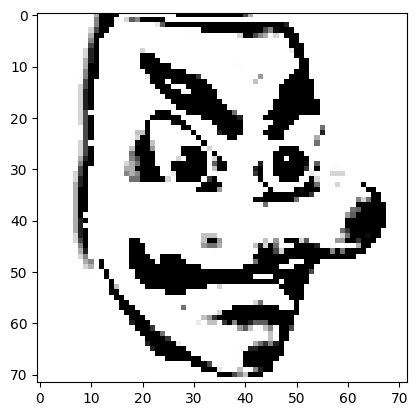

In [169]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[87]).astype('uint8'), cv2.COLOR_BGR2RGB))

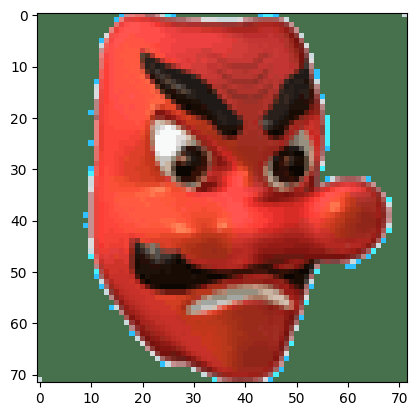

In [170]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[87]).astype('uint8'), cv2.COLOR_BGR2RGB))

**## Define GAN Model**

> Блок с отступами



In [54]:
img_shape = (128, 128, 1)

g_model = generator(img_shape)

d_model = discriminator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)


______GENERATOR______:
  (None, 128, 128, 1)
---------Deconv2d---------:
 layer_in.shape =  (None, 1, 1, 512) , skip_in.shape =  (None, 2, 2, 512) 

Upsampling: d.shape =  (None, 2, 2, 512)
Upsampling -> conv2d: d.shape =  (None, 2, 2, 512)
---------Deconv2d---------:
 layer_in.shape =  (None, 2, 2, 1024) , skip_in.shape =  (None, 4, 4, 512) 

Upsampling: d.shape =  (None, 4, 4, 1024)
Upsampling -> conv2d: d.shape =  (None, 4, 4, 512)
---------Deconv2d---------:
 layer_in.shape =  (None, 4, 4, 1024) , skip_in.shape =  (None, 8, 8, 512) 

Upsampling: d.shape =  (None, 8, 8, 1024)
Upsampling -> conv2d: d.shape =  (None, 8, 8, 512)
---------Deconv2d---------:
 layer_in.shape =  (None, 8, 8, 1024) , skip_in.shape =  (None, 16, 16, 256) 

Upsampling: d.shape =  (None, 16, 16, 1024)
Upsampling -> conv2d: d.shape =  (None, 16, 16, 256)
---------Deconv2d---------:
 layer_in.shape =  (None, 16, 16, 512) , skip_in.shape =  (None, 32, 32, 128) 

Upsampling: d.shape =  (None, 32, 32, 512)
Upsampl

In [55]:
gan_model.summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 generator (Functional)         (None, 128, 128, 1)  41819545    ['input_16[0][0]']               
                                                                                                  
 discriminator (Functional)     (None, 32, 32, 1)    535107      ['input_16[0][0]',               
                                                                  'generator[0][0]']              
                                                                                                

In [93]:
opt = Adam(learning_rate=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

## Start Training

In [94]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo],
      '/content/drive/MyDrive/Training_data_17.09.2023/Pretrained_emojis', n_epochs = 1, n_batch=16)

 ========== Epoch 1 ========== 


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


select a batch of real samples
generate a batch of fake samples: X_realA.shape:  (16, 128, 128, 1) X_realB.shape is (16, 128, 128, 3) 

generate fake instance, samples.shape:  (16, 128, 128, 1)
1/1 [==============================] - 3s 3s/step
update discriminator for generated samples
update the generator
X_realAa.shape is  (16, 128, 128, 3) X_realB.shape is  (16, 128, 128, 3) y_real.shape is  (16, 32, 32, 1)


Batch : 1, D Loss : 1.227 | G Loss : 73.932
select a batch of real samples
generate a batch of fake samples: X_realA.shape:  (16, 128, 128, 1) X_realB.shape is (16, 128, 128, 3) 

generate fake instance, samples.shape:  (16, 128, 128, 1)
1/1 [==============================] - 3s 3s/step
update discriminator for generated samples
update the generator
X_realAa.shape is  (16, 128, 128, 3) X_realB.shape is  (16, 128, 128, 3) y_real.shape is  (16, 32, 32, 1)
Batch : 2, D Loss : 1.679 | G Loss : 90.100
select a batch of real samples
generate a batch of fake samples: X_realA.shape:  (16, 128, 128, 1) X_realB.shape is (16, 128, 128, 3) 

generate fake instance, samples.shape:  (16, 128, 128, 1)
1/1 [==============================] - 5s 5s/step
update discriminator for generated samples
update the generator
X_realAa.shape is  (16, 128, 128, 3) X_realB.shape is  (16, 128, 128, 3) y_real.shape is  (16, 32, 32, 1)
Batch : 3, D Loss : 1.799 | G Loss : 77.846
select a batch of real samples
generate 

UnimplementedError: ignored

(72, 72)

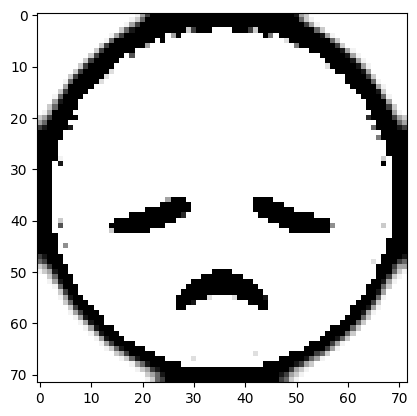

In [190]:
from PIL import Image
image = Image.open('/content/drive/MyDrive/Training_data_17.09.2023/Full_Training-sketches/87.png')
arr = np.asarray(image)
plt.imshow(arr, cmap='gray')
arr.shape

In [191]:
arr = arr[tf.newaxis, ..., tf.newaxis]
new_arr = tf.image.resize(arr, (128, 128), 'bicubic')
new_arr.shape

TensorShape([1, 128, 128, 1])

In [109]:
target_dir ='/content/drive/MyDrive/Training_data_17.09.2023/Summarizing_performance_haha/'

g_model.save(target_dir + 'g_model.h5')

# save the discriminator model
d_model.save(target_dir + 'd_model.h5')

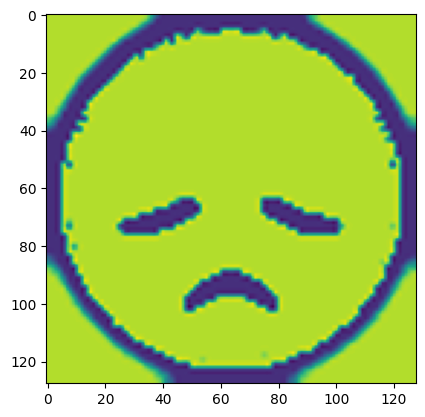

In [192]:
plt.imshow(new_arr[0])

In [188]:
new_arr = tf.concat([new_arr, new_arr, new_arr], axis=3)
new_arr.shape

TensorShape([1, 128, 128, 3])

In [193]:
new_arr = gan_model(new_arr)

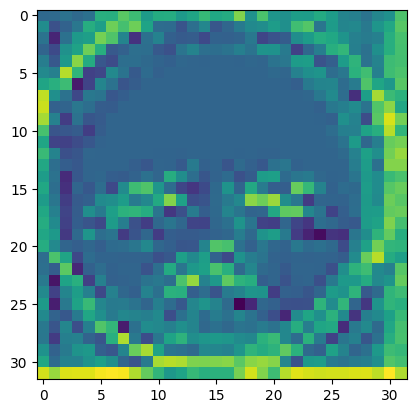

In [194]:
plt.imshow(new_arr[0][0])

In [19]:
# len(blue_sketch), len(blue_photo)

(1798, 1798)

In [62]:
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 64, 64, 64)   1088        ['input_13[0][0]']               
                                                                                                  
 leaky_re_lu_33 (LeakyReLU)     (None, 64, 64, 64)   0           ['conv2d_54[0][0]']              
                                                                                                  
 conv2d_55 (Conv2D)             (None, 32, 32, 128)  131200      ['leaky_re_lu_33[0][0]'] 

In [ ]:
# g_model.load_weights('/content/drive/MyDrive/Training_data_17.09.2023/Pretrained/My_little_modelsg_model.h5')
d_model.load_weights('/content/drive/MyDrive/Training_data_17.09.2023/Pretrained/My_little_modelsd_model.h5')

In [33]:
summarize_performance(1, g_model, d_model, dataset,
                      '/content/drive/MyDrive/Training_data_17.09.2023/Summarizing_performance_haha/')

1/1 [==============================] - 0s 80ms/step


>Saved: plot_000002.png and g_model & d_model


In [85]:
g_model.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_54 (Conv2D)             (None, 64, 64, 64)   1088        ['input_13[0][0]']               
                                                                                                  
 leaky_re_lu_33 (LeakyReLU)     (None, 64, 64, 64)   0           ['conv2d_54[0][0]']              
                                                                                                  
 conv2d_55 (Conv2D)             (None, 32, 32, 128)  131200      ['leaky_re_lu_33[0][0]'] 

In [39]:
d_model.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 concatenate_19 (Concatenat  (None, 128, 128, 2)          0         ['input_9[0][0]',             
 e)                                                                  'input_10[0][0]']            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 64, 64, 64)           2112      ['concatenate_19[0